# CDS513 Predictive Business Analytics - Assignment 1
## *Topic 3 - The Movie Dataset*

# Recommender Systems (Content Based)

## Import necessary packages

In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
# pd.set_option("display.max_columns", None)

## Data Exploration and Pre-Processing

In [2]:
# import ratings file
# df = pd.read_csv("ratings.csv")
# df = pd.read_csv("ratings_small.csv", dtype={"userId": int, "movieId": str, "rating": float, "timestamp":int})
df = pd.read_csv("ratings_small.csv")
df.head(10)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [3]:
# check for null values
df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [4]:
# convert the timestamp from epoch to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")

In [5]:
df.dtypes

userId                int64
movieId               int64
rating              float64
timestamp    datetime64[ns]
dtype: object

In [6]:
# loading links_small.csv
links_df = pd.read_csv("links_small.csv")
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [7]:
print(links_df.shape)
links_df.isnull().sum()

(9125, 3)


movieId     0
imdbId      0
tmdbId     13
dtype: int64

In [8]:
links_df.dropna(inplace=True)
links_df.shape

(9112, 3)

In [9]:
links_df["tmdbId"] = links_df["tmdbId"].apply(lambda x: int(x))
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862
1,2,113497,8844
2,3,113228,15602
3,4,114885,31357
4,5,113041,11862


In [10]:
# merge user ratings file with links file. 
df = df.merge(links_df[["movieId", "tmdbId"]], left_on="movieId", right_on="movieId")
df.head()

,userId,movieId,rating,timestamp,tmdbId
0,1,31,2.5,2009-12-14 02:52:24,9909
1,7,31,3.0,1996-12-29 14:12:30,9909
2,31,31,4.0,2010-05-11 01:39:13,9909
3,32,31,4.0,1996-06-15 08:47:20,9909
4,36,31,3.0,1996-11-03 21:40:02,9909


In [11]:
# import movies dataset
movies = pd.read_csv("movies_metadata.csv", low_memory=False)
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [12]:
movies.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

The column adult in the movies_metatdata.csv indicates whether the film is adult rated or not. <br>
As such, we are expecting only True or False value. <br>
The following commands are executed to check consistency of data. 

In [13]:
# check for inconsistent data
movies["adult"].unique()

array(['False', 'True', ' - Written by Ørnås',
       ' Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.',
       ' Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.'],
      dtype=object)

There are rows in the adult column which have values other than True and False. <br>
Those values will be filtered out 

In [14]:
movies = movies[(movies["adult"]=="True") | (movies["adult"]=="False")]

In [15]:
movies.to_csv("movies_metadata_filtered.csv", index=False)

In [16]:
import ast
movies = pd.read_csv("movies_metadata_filtered.csv", converters={"genres": ast.literal_eval}, low_memory=False)

In [17]:
movies.dtypes

adult                       bool
belongs_to_collection     object
budget                     int64
genres                    object
homepage                  object
id                         int64
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity               float64
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [18]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [19]:
movies.shape

(45463, 24)

Some data are stored in list of dictionaries, for instance genre and spoken_language. A function is written to change the list into a simple string

In [20]:
def get_item(x, keyname): 
    genre = ''
    for d in x: 
        genre += d[keyname]
        genre += ', '
    if len(genre)==0:
        genre = " "
    else: 
        genre = genre[:-2]
    return genre

movies["genre"] = movies["genres"].apply(get_item, keyname=("name"))
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,genre
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"Animation, Comedy, Family"
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"Adventure, Fantasy, Family"
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"Romance, Comedy"
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"Comedy, Drama, Romance"
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,Comedy


In [21]:
# merge dataframe
df = df.merge(movies[["id", "title"]], how="left", left_on="tmdbId", right_on="id")
print(df.shape)
df.head(10)

(99973, 7)


,userId,movieId,rating,timestamp,tmdbId,id,title
0,1,31,2.5,2009-12-14 02:52:24,9909,9909.0,Dangerous Minds
1,7,31,3.0,1996-12-29 14:12:30,9909,9909.0,Dangerous Minds
2,31,31,4.0,2010-05-11 01:39:13,9909,9909.0,Dangerous Minds
3,32,31,4.0,1996-06-15 08:47:20,9909,9909.0,Dangerous Minds
4,36,31,3.0,1996-11-03 21:40:02,9909,9909.0,Dangerous Minds
5,39,31,3.0,1996-05-19 16:59:17,9909,9909.0,Dangerous Minds
6,73,31,3.5,2009-10-15 07:31:00,9909,9909.0,Dangerous Minds
7,88,31,3.0,2009-04-15 00:32:39,9909,9909.0,Dangerous Minds
8,96,31,2.5,2008-10-06 01:25:31,9909,9909.0,Dangerous Minds
9,110,31,4.0,1996-08-15 09:18:15,9909,9909.0,Dangerous Minds


In [22]:
# check for null values
print(df.shape)
df.isnull().sum()

(99973, 7)


userId         0
movieId        0
rating         0
timestamp      0
tmdbId         0
id           123
title        123
dtype: int64

In [23]:
# filter out NA values on merged columns
df.dropna(subset=["title"], inplace=True)

# drop duplicated id column
df = df[["userId", "tmdbId", "rating", "timestamp", "title"]]
df.head(10)

,userId,tmdbId,rating,timestamp,title
0,1,9909,2.5,2009-12-14 02:52:24,Dangerous Minds
1,7,9909,3.0,1996-12-29 14:12:30,Dangerous Minds
2,31,9909,4.0,2010-05-11 01:39:13,Dangerous Minds
3,32,9909,4.0,1996-06-15 08:47:20,Dangerous Minds
4,36,9909,3.0,1996-11-03 21:40:02,Dangerous Minds
5,39,9909,3.0,1996-05-19 16:59:17,Dangerous Minds
6,73,9909,3.5,2009-10-15 07:31:00,Dangerous Minds
7,88,9909,3.0,2009-04-15 00:32:39,Dangerous Minds
8,96,9909,2.5,2008-10-06 01:25:31,Dangerous Minds
9,110,9909,4.0,1996-08-15 09:18:15,Dangerous Minds


In [24]:
print(df.shape)
df.isnull().sum()

(99850, 5)


userId       0
tmdbId       0
rating       0
timestamp    0
title        0
dtype: int64

Prevent user cold start by keeping dataset of users with at least 5 reviews. 

In [25]:
users_interactions_count_df = df.groupby(["userId", 'tmdbId']).size().groupby('userId').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['userId']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

# users: 671
# users with at least 5 interactions: 671


In [26]:
print('# of interactions: %d' % len(df))
interactions_from_selected_users_df = df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'userId',
               right_on = 'userId')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 99850
# of interactions from users with at least 5 interactions: 99850


Check whether there are duplicated reviews on the same movie by the same review. 

In [27]:
# count number of reviews done by a user on a movie for multiple times
reviews_by_users_movie = interactions_from_selected_users_df.groupby(["userId", "tmdbId"])["rating"].count().reset_index()
print(f'Number of duplicated reviews done on a movie by user: {reviews_by_users_movie[reviews_by_users_movie["rating"]>1]["rating"].count()}')

Number of duplicated reviews done on a movie by user: 40


Average out the reviews

In [28]:
reviews_full_df = interactions_from_selected_users_df.groupby(["userId", "tmdbId"])["rating"].mean().reset_index()
print(f"Number of unique user/movie reviews: {len(reviews_full_df)}")
reviews_full_df.head(10)

Number of unique user/movie reviews: 99810


,userId,tmdbId,rating
0,1,97,4.0
1,1,152,2.5
2,1,665,2.0
3,1,783,2.0
4,1,819,3.0
5,1,847,2.0
6,1,1051,4.0
7,1,1103,2.0
8,1,1598,2.0
9,1,3179,1.0


## Evaluation

Using holdout method for train-test split. 

In [29]:
reviews_train_df, reviews_test_df = train_test_split(reviews_full_df, 
                                                     stratify = reviews_full_df["userId"], 
                                                     test_size = 0.2, 
                                                     random_state = 999)

print(f"Number of interactions on train set: {len(reviews_train_df)}")
print(f"Number of interactions on test set: {len(reviews_test_df)}")

Number of interactions on train set: 79848
Number of interactions on test set: 19962


In [30]:
reviews_test_df.head()

,userId,tmdbId,rating
96166,644,522,5.0
91407,607,2323,3.5
49436,362,24,4.0
93345,623,30839,4.0
34071,243,2114,3.5


In [31]:
#Indexing by userId to speed up the searches during evaluation
interactions_full_indexed_df =  reviews_full_df.set_index('userId')
interactions_train_indexed_df = reviews_train_df.set_index('userId')
interactions_test_indexed_df =  reviews_test_df.set_index('userId')

In [32]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[person_id]['tmdbId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [33]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(movies['id'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    
    def _count_hit_at_top_n(self, interacted_items, recommended_items, topn):        
        topn_movies = set(recommended_items[:topn])
        count = len(topn_movies & interacted_items)

        return count

    def _average_precision_top_n(self, interacted_items, recommended_items, topn):        
        precision = 0
        for n in range(1, topn+1): 
            topn_movies = set(list(recommended_items)[:n])
            p = len(topn_movies & interacted_items)
            precision += p/n
            # print(f"n: {n}, p: {p}, pre: {precision}")
        
        average_precision = precision/topn
        # print(average_precision)
        return average_precision

    def get_prob(self, interacted_items, recommended_items_df): 
        prob = []
        for key, item in recommended_items_df.iterrows(): 
            if item["tmdbId"] in interacted_items:
                prob.append({"true": 1, "prob": item["recStrength"]}) 
            else: 
                prob.append({"true": 0, "prob": item["recStrength"]}) 
        return prob

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['tmdbId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['tmdbId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['tmdbId'])])  
            # person_interacted_items_testset = set(interacted_values_testset['title'])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        # print(person_recs_df.head())
        # person_recs_id = set(person_recs_df["movieId"])
        person_recs_id = person_recs_df.drop_duplicates(subset="tmdbId")["tmdbId"].to_list()
        # print(person_recs_id)

        p_hits_at_5_count = self._count_hit_at_top_n(person_interacted_items_testset, person_recs_id, 5)
        p_hits_at_10_count = self._count_hit_at_top_n(person_interacted_items_testset, person_recs_id, 10)        
        p_hits_at_20_count = self._count_hit_at_top_n(person_interacted_items_testset, person_recs_id, 20)  

        #Precision is the ratio of correct recommendations to the number of recommendations made
        precision_at_5 = p_hits_at_5_count / float(5)
        precision_at_10 = p_hits_at_10_count / float(10)
        precision_at_20 = p_hits_at_20_count / float(20)

        average_precision_at_5 = self._average_precision_top_n(person_interacted_items_testset, person_recs_id, 5)
        average_precision_at_10 = self._average_precision_top_n(person_interacted_items_testset, person_recs_id, 10)
        average_precision_at_20 = self._average_precision_top_n(person_interacted_items_testset, person_recs_id, 20)

        ## For recall 
        hits_at_5_count = 0
        hits_at_10_count = 0
        hits_at_20_count = 0

        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))
                                                                        #   seed=999)

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['tmdbId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['tmdbId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10
            hit_at_20, index_at_20 = self._verify_hit_top_n(item_id, valid_recs, 20)
            hits_at_20_count += hit_at_20

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)
        recall_at_20 = hits_at_20_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'hits@20_count':hits_at_20_count,  
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10,        
                          'recall@20': recall_at_20,    
                          'interacted_count': interacted_items_count_testset,
                          'p_hits@5_count':p_hits_at_5_count, 
                          'p_hits@10_count':p_hits_at_10_count, 
                          'p_hits@20_count':p_hits_at_20_count, 
                          'precision@5': precision_at_5,
                          'precision@10': precision_at_10,
                          'precision@20': precision_at_20,
                          'average_p@5': average_precision_at_5,
                          'average_p@10': average_precision_at_10,
                          'average_p@20': average_precision_at_20}

        prob = self.get_prob(person_interacted_items_testset, person_recs_df)

        return person_metrics, prob

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        probs = []
        i = 0
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics, prob = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
            probs += (prob)
            i += 1
        print('%d users processed' % idx)
        print(i)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_precision_at_5 = detailed_results_df['p_hits@5_count'].sum() / float(5*i)
        global_precision_at_10 = detailed_results_df['p_hits@10_count'].sum() / float(10*i)
        global_precision_at_20 = detailed_results_df['p_hits@20_count'].sum() / float(20*i)
        mean_average_precision_at_5 = detailed_results_df['average_p@5'].mean()
        mean_average_precision_at_10 = detailed_results_df['average_p@10'].mean()
        mean_average_precision_at_20 = detailed_results_df['average_p@20'].mean()
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_20 = detailed_results_df['hits@20_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'precision@5': global_precision_at_5,
                          'precision@10': global_precision_at_10,
                          'precision@20': global_precision_at_20,
                          'map@5': mean_average_precision_at_5,
                          'map@10': mean_average_precision_at_10,
                          'map@20': mean_average_precision_at_20,
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10,
                          'recall@20': global_recall_at_20}

        probs_df = pd.DataFrame(probs)
        
        return global_metrics, detailed_results_df, probs_df
    
model_evaluator = ModelEvaluator()    

## Content based filtering

In [34]:
# merge movies dataset with its respective keywords
keywords = pd.read_csv("keywords.csv", converters={"keywords": ast.literal_eval})
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [35]:
# keywords are stored in list of dictionaries. get_item function created earlier is used to obtain the respective keywords. 
keywords["keyword"] = keywords["keywords"].apply(get_item, keyname="name")
keywords.head(10)

,id,keywords,keyword
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","jealousy, toy, boy, friendship, friends, rival..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","board game, disappearance, based on children's..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","fishing, best friend, duringcreditsstinger, ol..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':...","based on novel, interracial relationship, sing..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","baby, midlife crisis, confidence, aging, daugh..."
5,949,"[{'id': 642, 'name': 'robbery'}, {'id': 703, '...","robbery, detective, bank, obsession, chase, sh..."
6,11860,"[{'id': 90, 'name': 'paris'}, {'id': 380, 'nam...","paris, brother brother relationship, chauffeur..."
7,45325,[],
8,9091,"[{'id': 949, 'name': 'terrorist'}, {'id': 1562...","terrorist, hostage, explosive, vice president"
9,710,"[{'id': 701, 'name': 'cuba'}, {'id': 769, 'nam...","cuba, falsely accused, secret identity, comput..."


In [36]:
for index, row in keywords["keyword"].iteritems():
    print(row)
    if index == 10: 
        break

jealousy, toy, boy, friendship, friends, rivalry, boy next door, new toy, toy comes to life
board game, disappearance, based on children's book, new home, recluse, giant insect
fishing, best friend, duringcreditsstinger, old men
based on novel, interracial relationship, single mother, divorce, chick flick
baby, midlife crisis, confidence, aging, daughter, mother daughter relationship, pregnancy, contraception, gynecologist
robbery, detective, bank, obsession, chase, shooting, thief, honor, murder, suspense, heist, betrayal, money, gang, cat and mouse, criminal mastermind, cult film, ex-con, heist movie, one last job, loner, bank job, neo-noir, gun fight, crime epic
paris, brother brother relationship, chauffeur, long island, fusion, millionaire
 
terrorist, hostage, explosive, vice president
cuba, falsely accused, secret identity, computer virus, secret base, secret intelligence service, kgb, satellite, special car, cossack, electromagnetic pulse, time bomb, st. petersburg russia, ejec

In [37]:
# merging the keyword column with the movies dataset
movies = movies.merge(keywords[["id", "keyword"]], how="left", left_on="id", right_on="id")
print(movies.shape)
movies.head(10)

(46483, 26)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,genre,keyword
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"Animation, Comedy, Family","jealousy, toy, boy, friendship, friends, rival..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"Adventure, Fantasy, Family","board game, disappearance, based on children's..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"Romance, Comedy","fishing, best friend, duringcreditsstinger, ol..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"Comedy, Drama, Romance","based on novel, interracial relationship, sing..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,Comedy,"baby, midlife crisis, confidence, aging, daugh..."
5,False,NaN,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,"Action, Crime, Drama, Thriller","robbery, detective, bank, obsession, chase, sh..."
6,False,NaN,58000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,11860,tt0114319,en,Sabrina,An ugly duckling having undergone a remarkable...,...,127.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,You are cordially invited to the most surprisi...,Sabrina,False,6.2,141.0,"Comedy, Romance","paris, brother brother relationship, chauffeur..."
7,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,45325,tt0112302,en,Tom and Huck,"A mischievous young boy, Tom Sawyer, witnesses...",...,97.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The Original Bad Boys.,Tom and Huck,False,5.4,45.0,"Action, Adventure, Drama, Family",
8,False,NaN,35000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0,"Action, Adventure, Thriller","terrorist, hostage, explosive, vice president"
9,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.mgm.com/view/movie/757/Goldeneye/,710,tt0113189,en,GoldenEye,James Bond must unmask the mysterious head of ...,...,130.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,No limits. No fears. No substitutes.,GoldenEye,False,6.6,1194.0,"Adventure, Action, Thriller","cuba, 

In [38]:
# check for null values
movies["keyword"].isnull().sum()

1

In [39]:
# there is a null value. tfid vectoriser does not work on null values. replace null value with an empty string. 
movies["keyword"].fillna("", inplace=True)
movies["overview"].fillna("", inplace=True)

In [40]:
# check for null values again
print(movies["keyword"].isnull().sum())
print(movies["overview"].isnull().sum())

0
0


In [41]:
# using genre and keywords as content

import nltk
nltk.download('stopwords')

# ignoring stopwords from English
stopwords_list = stopwords.words('english')

# trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords, 
vectorizer = TfidfVectorizer(analyzer='word', 
                             ngram_range=(1, 2),
                             min_df=0.003,
                             max_df=0.5, 
                             max_features=5000,
                             stop_words=stopwords_list)

item_ids = movies["id"].tolist()
tfidf_matrix = vectorizer.fit_transform(movies['genre'] + " " + movies['keyword'] + " " + movies['overview'])
# tfidf_matrix = vectorizer.fit_transform(movies['genre'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\40501\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\40501\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<46483x2186 sparse matrix of type '<class 'numpy.float64'>'
	with 1092786 stored elements in Compressed Sparse Row format>

Model user profile by taking all the item profiles the user has interacted and average them. Higher ratings will have higher strength in final profile. 

In [42]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['tmdbId'])
    
    user_item_strengths = np.array(interactions_person_df['rating']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = reviews_train_df[reviews_train_df['tmdbId'] \
                                                   .isin(movies['id'])].set_index('userId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [43]:
user_profiles = build_users_profiles()
len(user_profiles)

c:\Users\40501\Anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\40501\Anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\40501\Anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\40501\Anaconda3\lib\site-

671

In [44]:
myprofile = user_profiles[10]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[10].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 2186)


,token,relevance
0,prison,0.194122
1,crime,0.175710
2,action,0.160745
3,thriller,0.142675
4,bus,0.117716
5,treasure,0.116147
6,comedy,0.113677
7,adventure,0.112395
8,man,0.111849
9,drama,0.107667


In [45]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['tmdbId', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'tmdbId', 
                                                          right_on = 'id')[['recStrength', 'tmdbId', 'title', 'original_title', 'original_language', 'genre', 'keyword']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(movies)

In [46]:
# cb_detailed_results_df.shape

In [47]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df, probs_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(20)

Evaluating Content-Based Filtering model...
670 users processed
671

Global metrics:
{'modelName': 'Content-Based', 'precision@5': 0.015499254843517139, 'precision@10': 0.013412816691505217, 'precision@20': 0.010804769001490314, 'map@5': 0.01745653253849975, 'map@10': 0.01549972795874435, 'map@20': 0.013727473292101772, 'recall@5': 0.12924556657649533, 'recall@10': 0.130548041278429, 'recall@20': 0.130548041278429}


,hits@5_count,hits@10_count,hits@20_count,recall@5,recall@10,recall@20,interacted_count,p_hits@5_count,p_hits@10_count,p_hits@20_count,precision@5,precision@10,precision@20,average_p@5,average_p@10,average_p@20,_person_id
98,24,25,25,0.050314,0.052411,0.052411,477,0,0,0,0.0,0.0,0.00,0.000000,0.000000,0.000000,547
18,13,13,13,0.034853,0.034853,0.034853,373,0,0,1,0.0,0.0,0.05,0.000000,0.000000,0.028893,564
10,28,29,29,0.080692,0.083573,0.083573,347,0,0,2,0.0,0.0,0.10,0.000000,0.000000,0.044289,624
40,26,26,26,0.076696,0.076696,0.076696,339,0,1,2,0.0,0.1,0.10,0.000000,0.033611,0.064220,15
44,39,39,39,0.121875,0.121875,0.121875,320,2,2,2,0.4,0.2,0.10,0.346667,0.302460,0.218107,73
48,13,13,13,0.048507,0.048507,0.048507,268,0,0,0,0.0,0.0,0.00,0.000000,0.000000,0.000000,452
47,18,18,18,0.069767,0.069767,0.069767,258,0,0,0,0.0,0.0,0.00,0.000000,0.000000,0.000000,468
9,26,26,26,0.123223,0.123223,0.123223,211,2,3,5,0.4,0.3,0.25,0.413333,0.356905,0.305995,380
182,17,17,17,0.083333,0.083333,0.083333,204,0,0,0,0.0,0.0,0.00,0.000000,0.000000,0.000000,311
83,15,15,15,0.074257,0.074257,0.074257,202,0,1,2,0.0,0.1,0.10,0.000000,0.021111,0.064874,30


0.7258302414302027


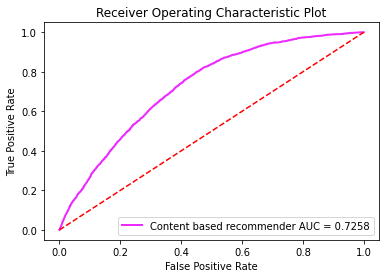

In [48]:
from sklearn.metrics import roc_auc_score, plot_roc_curve
import recmetrics

auc = roc_auc_score(probs_df["true"], probs_df["prob"])
print(auc)

recmetrics.roc_plot(probs_df["true"], probs_df["prob"], model_names="Content based recommender", figsize=(10,8))

## Testing

In [49]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id].merge(movies, how = 'left', 
                                                      left_on = 'tmdbId', 
                                                      right_on = 'id') \
                          .sort_values('rating', ascending = False)[['rating', 
                                                                          'id',
                                                                          'title', 'original_title', 'original_language', 'genre', 'keyword']]

In [56]:
inspect_interactions(248, test_set=True)

,rating,id,title,original_title,original_language,genre,keyword
0,5.0,2039,Moonstruck,Moonstruck,en,"Comedy, Drama, Romance","new york, love letter, lover, full moon"
2,5.0,510,One Flew Over the Cuckoo's Nest,One Flew Over the Cuckoo's Nest,en,Drama,"individual, rebel, self-destruction, wheelchai..."
3,5.0,28,Apocalypse Now,Apocalypse Now,en,"Drama, War","guerrilla, river, vietnam, vietcong, cambodia,..."
4,5.0,5925,The Great Escape,The Great Escape,en,"Adventure, Drama, History, Thriller, War","based on novel, optimism, switzerland, basebal..."
5,5.0,185,A Clockwork Orange,A Clockwork Orange,en,"Science Fiction, Drama","prison, street gang, rape, adolescence, sexual..."
16,5.0,348,Alien,Alien,en,"Horror, Action, Thriller, Science Fiction","android, countdown, space marine, space suit, ..."
9,5.0,192,The Name of the Rose,The Name of the Rose,en,"Drama, Thriller, Mystery","christianity, library, inquisition, monk, pois..."
15,5.0,387,Das Boot,Das Boot,de,"Action, Drama, History, War, Adventure","terror, submarine, based on novel, atlantic oc..."
14,5.0,120,The Lord of the Rings: The Fellowship of the Ring,The Lord of the Rings: The Fellowship of the Ring,en,"Adventure, Fantasy, Action","elves, dwarves, orcs, middle-earth (tolkien), ..."
13,4.0,2164,Stargate,Stargate,en,"Action, Adventure, Science Fiction","space travel, teleportation, uprising, shot to..."


In [51]:
content_based_recommender_model.recommend_items(248, topn=20, verbose=True)

,recStrength,tmdbId,title,original_title,original_language,genre,keyword
0,0.504758,166610,The Ducktators,The Ducktators,en,"Comedy, Animation","war, war propaganda"
1,0.494126,13922,The Great Raid,The Great Raid,en,"Action, History, War","based on novel, world war ii, prisoners of war..."
2,0.487387,4820,Never So Few,Never So Few,en,"Action, Drama, War","world war ii, burma"
3,0.486006,227306,Unbroken,Unbroken,en,"Drama, War","world war ii, prisoners of war, biography, spo..."
4,0.485977,11422,Midway,Midway,en,"Action, Drama, History, War","japanese, world war ii, midway, soldier, american"
5,0.477430,33611,The Robbery of the Third Reich,Pljačka Trećeg rajha,sr,"Comedy, War","robbery, world war ii"
6,0.475366,41205,The Unknown Soldier,Tuntematon sotilas,en,"Drama, War",world war ii
7,0.466459,10105,Saints and Soldiers,Saints and Soldiers,en,"Action, Adventure, Drama, History, War","winter, belgium, world war ii, nazis, bravery,..."
8,0.463714,633,Soldier of Orange,Soldaat van Oranje,nl,"Drama, History, Thriller, War","netherlands, world war ii, brotherhood, student"
9,0.461093,94135,Yesterday's Enemy,Yesterday's Enemy,en,"Drama, War","japanese, world war ii, burma, army, british, ..."


### Visualise the recommendations to the user's interaction

In [52]:
USER_ID = 248
TOP_REC = 20

def rec_interaction_check(rec_model, user_id, topn): 
    recs = rec_model.recommend_items(user_id, topn=topn, verbose=True)
    interactions = inspect_interactions(user_id, test_set=False)

    interactions["interacted"] = "yes"

    recs = recs.merge(interactions[["rating", "id", "interacted"]], how="left", left_on="tmdbId", right_on="id")
    recs["interacted"] = recs["interacted"].fillna("no")
    recs["color"] = recs["interacted"].apply(lambda x: "green" if x=="yes" else "red")

    return recs

recs = rec_interaction_check(content_based_recommender_model, USER_ID, TOP_REC)

In [53]:
recs

,recStrength,tmdbId,title,original_title,original_language,genre,keyword,rating,id,interacted,color
0,0.504758,166610,The Ducktators,The Ducktators,en,"Comedy, Animation","war, war propaganda",NaN,NaN,no,red
1,0.494126,13922,The Great Raid,The Great Raid,en,"Action, History, War","based on novel, world war ii, prisoners of war...",NaN,NaN,no,red
2,0.487387,4820,Never So Few,Never So Few,en,"Action, Drama, War","world war ii, burma",NaN,NaN,no,red
3,0.486006,227306,Unbroken,Unbroken,en,"Drama, War","world war ii, prisoners of war, biography, spo...",NaN,NaN,no,red
4,0.485977,11422,Midway,Midway,en,"Action, Drama, History, War","japanese, world war ii, midway, soldier, american",NaN,NaN,no,red
5,0.477430,33611,The Robbery of the Third Reich,Pljačka Trećeg rajha,sr,"Comedy, War","robbery, world war ii",NaN,NaN,no,red
6,0.475366,41205,The Unknown Soldier,Tuntematon sotilas,en,"Drama, War",world war ii,NaN,NaN,no,red
7,0.466459,10105,Saints and Soldiers,Saints and Soldiers,en,"Action, Adventure, Drama, History, War","winter, belgium, world war ii, nazis, bravery,...",NaN,NaN,no,red
8,0.463714,633,Soldier of Orange,Soldaat van Oranje,nl,"Drama, History, Thriller, War","netherlands, world war ii, brotherhood, student",NaN,NaN,no,red
9,0.461093,94135,Yesterday's Enemy,Yesterday's Enemy,en,"Drama, War","japanese, world war ii, burma, army, british, ...",NaN,NaN,no,red


In [54]:
import plotly.express as px
fig = px.treemap(recs, path=['title'],values=(recs["recStrength"]**3), width=800, height=600)
fig.update_layout(
    treemapcolorway = recs["color"], #defines the colors in the treemap
    margin = dict(t=50, l=25, r=25, b=25), 
    title = f"Top {TOP_REC} Recommendations for User {USER_ID} Using {content_based_recommender_model.MODEL_NAME} Recommender System")
fig.show()

[Text(0.5, 1.0, 'Top 20 Recommendations for User 248 Recommender System')]

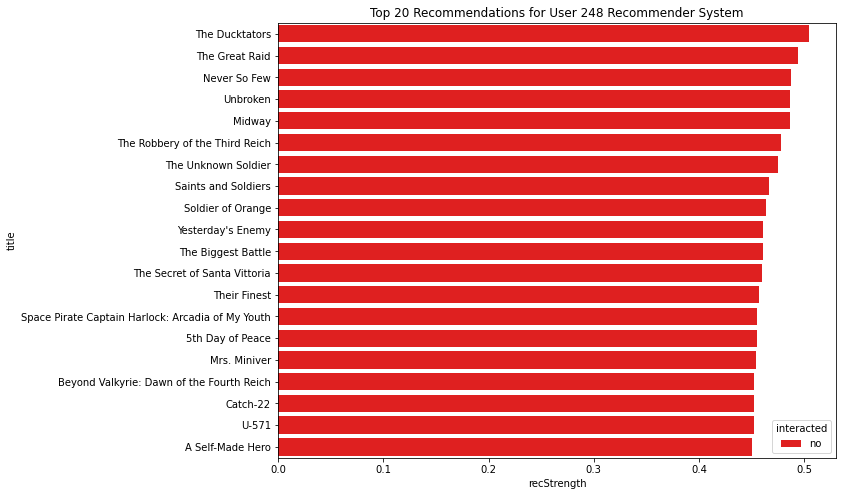

In [55]:
import seaborn as sns

palette ={"yes": "green", "no": "red"}

plt.figure(figsize=(10, 8))
sns.barplot(data=recs, y="title", x="recStrength", hue='interacted', dodge=False, palette=palette).set(title=f"Top {TOP_REC} Recommendations for User {USER_ID} Recommender System")